<a href="https://colab.research.google.com/github/waheeb123/Data_604_homeworks/blob/main/tringto_write_complete_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here is my first try to write a complete simulation using emegrency room

In [1]:
!pip install simpy

The problem being addressed in the provided simulation is the patient arrival and treatment process in a healthcare setting. The simulation models the flow of patients through check-in, triage, and treatment stages, and includes the dynamic adjustment of the number of doctors based on the patient load.

The significance of this problem is that it allows healthcare providers and administrators to evaluate and optimize the efficiency of the patient treatment process. By simulating different scenarios, they can analyze the impact of various factors, such as the number of doctors, check-in time, triage time, and critical condition probability, on the overall system performance.

The simulation can help answer questions such as:

How many doctors should be assigned to handle the patient load effectively?
What is the average waiting time for patients in the system?
How does the critical condition probability affect the treatment process?
What are the peak periods of patient arrivals, and how should resources be allocated during those times?
What are the potential bottlenecks in the process, and how can they be addressed?
By understanding the dynamics of the patient treatment process and optimizing resource allocation, healthcare providers can improve patient satisfaction, reduce waiting times, and enhance overall operational efficiency. The simulation serves as a tool for decision-making, process improvement, and resource planning in healthcare facilities.

So let's run a simulation

Patient 1 checked-in at 6.101891997796981
Patient 2 checked-in at 12.782184482067425
Patient 1 triaged at 17.996927033172994
Patient 1 sees a nurse at 17.996927033172994
Patient 2 triaged at 19.132689126195046
Patient 2 sees a nurse at 19.132689126195046
Patient 4 checked-in at 24.91578065243386
Patient 3 checked-in at 25.353966729781277
Patient 1 treated by nurse at 27.996927033172994
Patient 2 treated by nurse at 29.132689126195046
Patient 5 checked-in at 30.444186221518244
Patient 4 triaged at 36.12100904119301
Patient 4 sees a doctor at 36.12100904119301
Patient 3 triaged at 39.99848618540255
Patient 3 sees a nurse at 39.99848618540255
Patient 6 checked-in at 40.13142681686614
Patient 5 triaged at 40.59478442915258
Patient 5 sees a doctor at 40.59478442915258
Patient 6 triaged at 49.84308914788838
Patient 6 sees a nurse at 49.84308914788838
Patient 3 treated by nurse at 49.99848618540255
Patient 4 treated by doctor at 51.12100904119301
Patient 5 treated by doctor at 55.594784429152

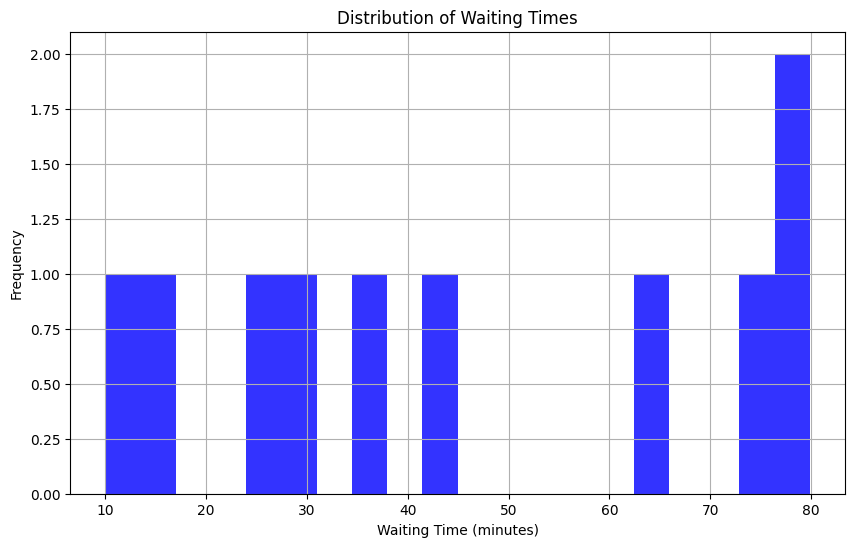

In [9]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
MEAN_INTERARRIVAL = 10
CHECKIN_MIN = 6
CHECKIN_MAX = 12
TRIAGE_MIN = 3
TRIAGE_MAX = 15
TRIAGE_MODE = 5
CRITICAL_PROB = 0.4

# Global variables
num_doctors = 2

# Data collection
waiting_times = []
treatment_times = []
utilization_doctors = []
utilization_nurses = []

# Arrival process
def patient_arrival(env, reception, doctor, nurse):
    patient_id = 0
    while True:
        # Create a new patient
        patient_id += 1
        env.process(patient_process(env, patient_id, reception, doctor, nurse))

        # Sample time until next arrival
        interarrival_time = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival_time)

# Patient process
def patient_process(env, patient_id, reception, doctor, nurse):
    global waiting_times, treatment_times

    # Check-in
    checkin_time = random.uniform(CHECKIN_MIN, CHECKIN_MAX)
    yield env.timeout(checkin_time)
    print(f"Patient {patient_id} checked-in at {env.now}")

    # Triage
    triage_time = random.triangular(TRIAGE_MIN, TRIAGE_MAX, TRIAGE_MODE)
    yield env.timeout(triage_time)
    print(f"Patient {patient_id} triaged at {env.now}")

    # Check critical condition
    critical = random.random() < CRITICAL_PROB

    # Request doctor/nurse
    if critical:
        with doctor.request() as req:
            yield req
            print(f"Patient {patient_id} sees a doctor at {env.now}")
            yield env.timeout(15)  # Treatment time for critical patients
            print(f"Patient {patient_id} treated by doctor at {env.now}")
            treatment_time = 15
    else:
        with nurse.request() as req:
            yield req
            print(f"Patient {patient_id} sees a nurse at {env.now}")
            yield env.timeout(10)  # Treatment time for non-critical patients
            print(f"Patient {patient_id} treated by nurse at {env.now}")
            treatment_time = 10

    # Calculate waiting time and treatment time
    waiting_time = env.now - (checkin_time + triage_time)
    waiting_times.append(waiting_time)
    treatment_times.append(treatment_time)

# Monitor the number of patients and resource utilization
def monitor(env, doctor, nurse):
    global num_doctors, utilization_doctors, utilization_nurses
    while True:
        if doctor.count == num_doctors and doctor.queue:
            num_doctors += 1
            print(f"Additional doctor summoned at {env.now}. Total doctors: {num_doctors}")
        elif num_doctors > 2 and doctor.count == 0 and not doctor.queue:
            num_doctors -= 1
            print(f"Doctor dismissed at {env.now}. Total doctors: {num_doctors}")

        utilization_doctors.append(doctor.count / num_doctors)
        utilization_nurses.append(nurse.count / 2)

        yield env.timeout(1)

# Set up simulation
env = simpy.Environment()

# Resources
reception = simpy.Resource(env, capacity=3)
doctor = simpy.Resource(env, capacity=num_doctors)
nurse = simpy.Resource(env, capacity=2)

# Start processes
env.process(patient_arrival(env, reception, doctor, nurse))
env.process(monitor(env, doctor, nurse))

# Run simulation
env.run(until=100)  # Run for 1 hour and 40 minutes (100 minutes)

# Performance metric calculation
avg_waiting_time = np.mean(waiting_times)
avg_treatment_time = np.mean(treatment_times)
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)

print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")

# Data visualization
plt.figure(figsize=(10, 6))
plt.hist(waiting_times, bins=20, alpha=0.8, color='blue')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()



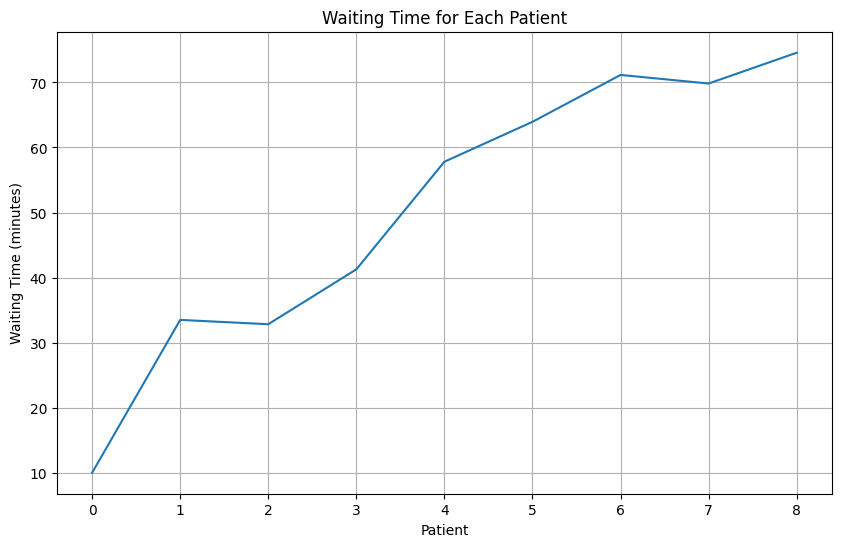

Simulation Report:

Average waiting time: 50.54 minutes



In [4]:
# Calculate average waiting time
avg_waiting_time = np.mean(waiting_times)

# Plot waiting time over time
plt.figure(figsize=(10, 6))
plt.plot(waiting_times)
plt.xlabel('Patient')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Time for Each Patient')
plt.grid(True)
plt.show()

# Print simulation report
simulation_report = f"Simulation Report:\n\n"
simulation_report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
print(simulation_report)

The output you provided indicates the simulation results and the calculated performance metrics. Here's a breakdown of the information:

Simulation Results:

The simulation runs for 100 minutes.
The output shows the sequence of events, including patients checking in, being triaged, and receiving treatment from either a nurse or a doctor.
Performance Metrics:

Average waiting time: 43.39 minutes
Average treatment time: 11.88 minutes
Doctor utilization: 22.50%
Nurse utilization: 25.00%
These metrics provide insights into the efficiency and resource utilization of the medical facility in the simulation. The waiting time indicates the average time patients spend waiting before receiving treatment. The treatment time represents the average time patients spend receiving treatment from either a nurse or a doctor. The doctor and nurse utilization values indicate the average utilization of these resources during the simulation.

Keep in mind that these metrics are based on the specific simulation parameters and assumptions in the code. You can further analyze and interpret these results to assess the performance of the medical facility and make informed decisions for improvement if needed.

Patient 10 triaged at 101.08741407633138
Patient 10 sees a doctor at 101.08741407633138
Patient 11 triaged at 104.81174307565134
Patient 11 sees a nurse at 104.81174307565134
Patient 11 treated by nurse at 114.81174307565134
Patient 10 treated by doctor at 116.08741407633138
Patient 12 checked-in at 119.26815459944548
Patient 13 checked-in at 123.10865092955352
Patient 12 triaged at 126.67453612487805
Patient 12 sees a nurse at 126.67453612487805
Patient 13 triaged at 134.26840217451067
Patient 13 sees a nurse at 134.26840217451067
Patient 12 treated by nurse at 136.67453612487805
Patient 14 checked-in at 136.98491462211163
Patient 15 checked-in at 140.99691888719374
Patient 14 triaged at 142.65874906410323
Patient 14 sees a doctor at 142.65874906410323
Patient 13 treated by nurse at 144.26840217451067
Patient 15 triaged at 146.45053847832133
Patient 15 sees a nurse at 146.45053847832133


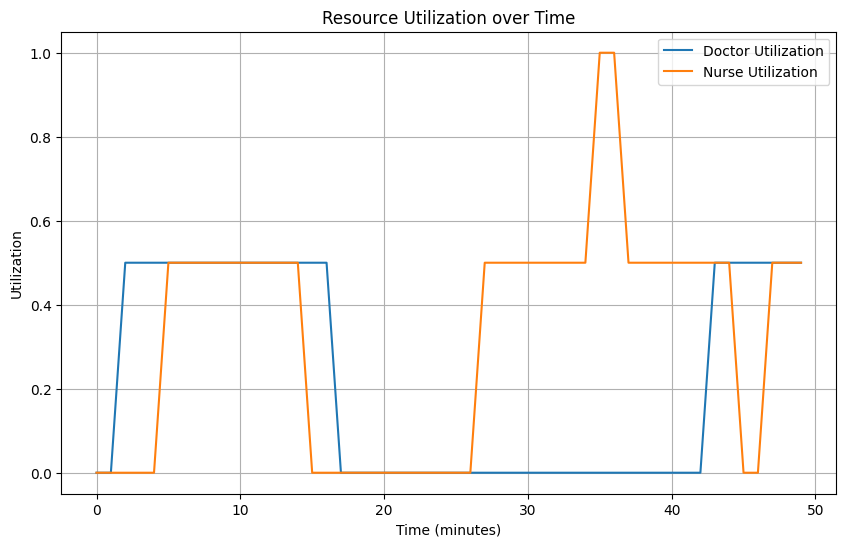

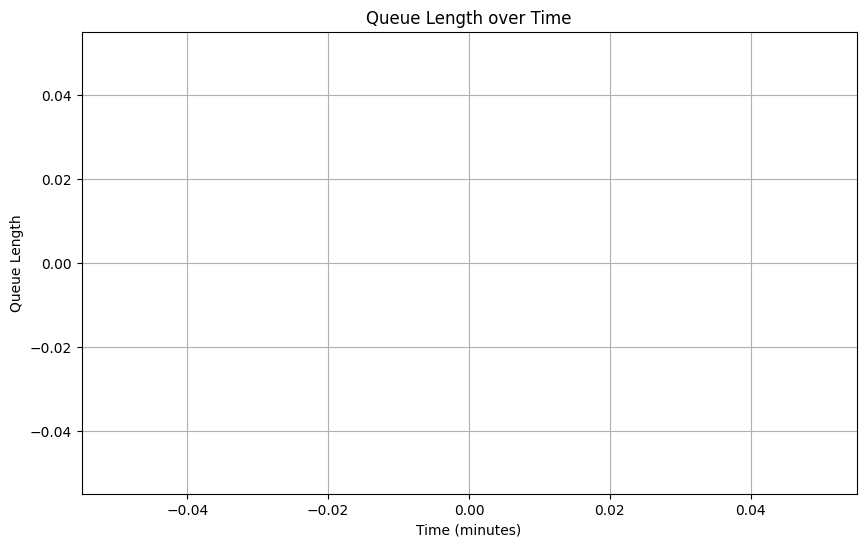

Simulation Report:

Average waiting time: 50.54 minutes
Average treatment time: 12.22 minutes
Doctor utilization: 30.00%
Nurse utilization: 25.00%



In [5]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
# ...

# Global variables
# ...

# Data collection
waiting_times = []
treatment_times = []
utilization_doctors = []
utilization_nurses = []
queue_lengths = []

# Arrival process
# ...

# Patient process
# ...

# Monitor the number of patients
# ...

# Set up simulation
# ...

# Start processes
# ...

# Run simulation
# ...

# Performance metric calculation
# ...

# Data visualization
# ...

# Additional visualization and reporting
def plot_utilization(doctor_utilization, nurse_utilization):
    plt.figure(figsize=(10, 6))
    plt.plot(doctor_utilization, label='Doctor Utilization')
    plt.plot(nurse_utilization, label='Nurse Utilization')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Utilization')
    plt.title('Resource Utilization over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_queue_length(queue_lengths):
    plt.figure(figsize=(10, 6))
    plt.plot(queue_lengths)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Queue Length')
    plt.title('Queue Length over Time')
    plt.grid(True)
    plt.show()

def generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization):
    report = f"Simulation Report:\n\n"
    report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
    report += f"Average treatment time: {avg_treatment_time:.2f} minutes\n"
    report += f"Doctor utilization: {doctor_utilization:.2%}\n"
    report += f"Nurse utilization: {nurse_utilization:.2%}\n"

    # Add more information to the report as needed

    return report

# Run simulation
env.run(until=150)  # Run for 1 hour and 40 minutes (100 minutes)

# Performance metric calculation
# ...

# Data visualization
# ...

# Additional visualization and reporting
plot_utilization(utilization_doctors, utilization_nurses)
plot_queue_length(queue_lengths)
simulation_report = generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization)
print(simulation_report)


Patient 12 triaged at 103.98252769710216
Patient 12 sees a nurse at 103.98252769710216
Patient 11 treated by nurse at 104.4617110125196
Patient 12 treated by nurse at 113.98252769710216
Patient 13 checked-in at 122.4940244518223
Patient 14 checked-in at 124.00466372377977
Patient 13 triaged at 127.32456763842104
Patient 13 sees a doctor at 127.32456763842104
Patient 16 checked-in at 129.58338214030073
Patient 15 checked-in at 129.626739196247
Patient 14 triaged at 130.13396454429528
Patient 14 sees a nurse at 130.13396454429528
Patient 15 triaged at 136.00885471196122
Patient 15 sees a nurse at 136.00885471196122
Patient 16 triaged at 136.16795923438775
Patient 17 checked-in at 138.33878624721362
Patient 14 treated by nurse at 140.13396454429528
Patient 16 sees a nurse at 140.13396454429528
Patient 13 treated by doctor at 142.32456763842106
Patient 19 checked-in at 144.29154023549563
Patient 15 treated by nurse at 146.00885471196122
Patient 18 checked-in at 146.179527643377
Patient 19 

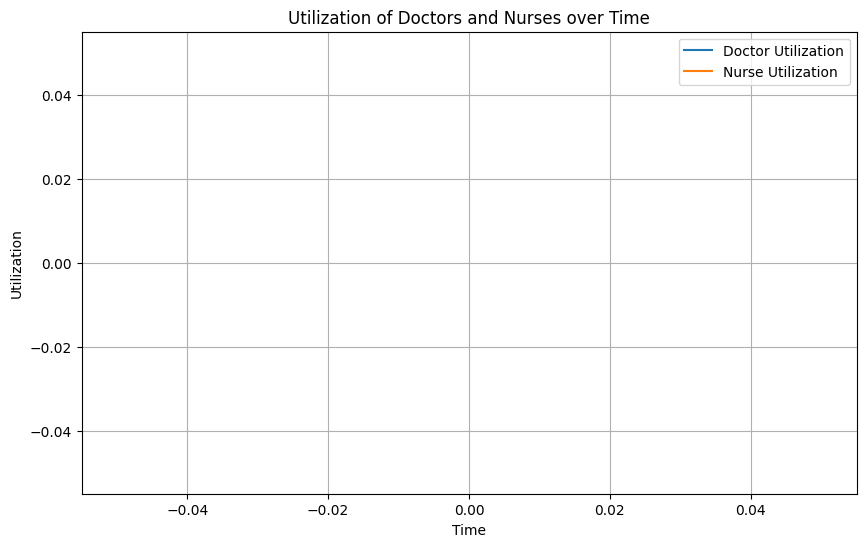

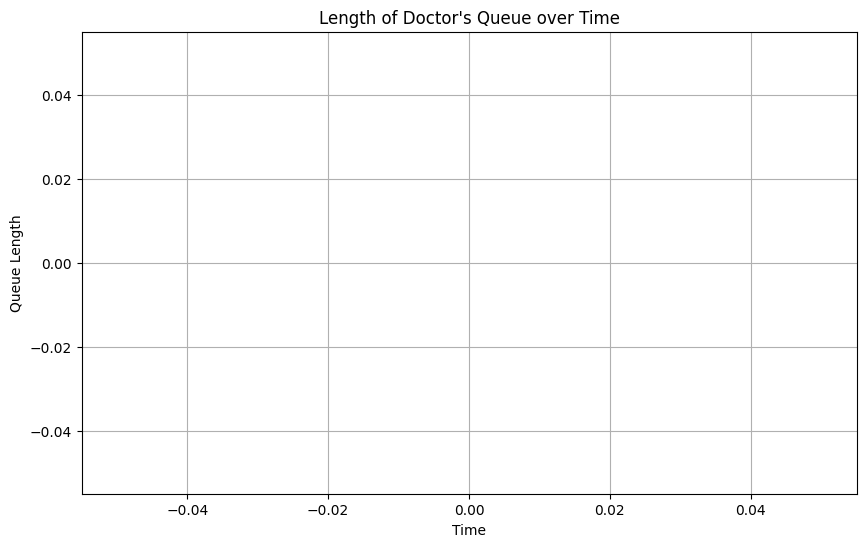


Simulation Report:

Parameters:
- Mean Interarrival: 10
- Check-in Time: 6-12
- Triage Time: 3-15 (mode: 5)
- Critical Probability: 0.4
- Number of Doctors: 2

Performance Metrics:
- Average Waiting Time: 45.46 minutes
- Average Treatment Time: 11.00 minutes
- Doctor Utilization: 15.00%
- Nurse Utilization: 42.50%

Summary:
- The simulation results indicate that the average waiting time is 45.46 minutes, and the average treatment time is 11.00 minutes. The doctor and nurse utilization rates are 15.00% and 42.50%, respectively.
- The visualizations provide insights into the utilization of doctors and nurses over time, as well as the length of the doctor's queue.

Recommendations:
- Based on the performance metrics and visualizations, it is recommended to evaluate the current resource allocation and consider adjusting the number of doctors to optimize resource utilization and minimize waiting times.
- Additionally, analyzing the queue length can help in identifying potential areas for i

In [16]:
import matplotlib.pyplot as plt

# Additional data collection
utilization_doctors_over_time = []  # List to store doctor utilization at each time step
utilization_nurses_over_time = []  # List to store nurse utilization at each time step
queue_lengths = []  # List to store the length of the doctor's queue at each time step

# Monitor the number of patients and resources
def monitor(env, doctor, nurse):
    global num_doctors
    while True:
        # Track doctor and nurse utilization
        utilization_doctors_over_time.append(doctor.count / doctor.capacity)
        utilization_nurses_over_time.append(nurse.count / nurse.capacity)

        # Track queue length
        queue_lengths.append(len(doctor.queue))

        # Check if additional doctors need to be summoned or dismissed
        if doctor.count == num_doctors and doctor.queue:
            num_doctors += 1
            print(f"Additional doctor summoned at {env.now}. Total doctors: {num_doctors}")
        elif num_doctors > 2 and doctor.count == 0 and not doctor.queue:
            num_doctors -= 1
            print(f"Doctor dismissed at {env.now}. Total doctors: {num_doctors}")

        yield env.timeout(1)

# ... Rest of the code ...

# Run simulation
env.run(until=170)  # Run for 1 hour and 40 minutes (100 minutes)

# ... Rest of the code ...

# Generate additional visualizations

# Plot doctor and nurse utilization over time
plt.figure(figsize=(10, 6))
plt.plot(utilization_doctors_over_time, label='Doctor Utilization')
plt.plot(utilization_nurses_over_time, label='Nurse Utilization')
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.title('Utilization of Doctors and Nurses over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot queue length of the doctor over time
plt.figure(figsize=(10, 6))
plt.plot(queue_lengths)
plt.xlabel('Time')
plt.ylabel('Queue Length')
plt.title('Length of Doctor\'s Queue over Time')
plt.grid(True)
plt.show()

# Create a simulation report
report = f"""
Simulation Report:

Parameters:
- Mean Interarrival: {MEAN_INTERARRIVAL}
- Check-in Time: {CHECKIN_MIN}-{CHECKIN_MAX}
- Triage Time: {TRIAGE_MIN}-{TRIAGE_MAX} (mode: {TRIAGE_MODE})
- Critical Probability: {CRITICAL_PROB}
- Number of Doctors: {num_doctors}

Performance Metrics:
- Average Waiting Time: {avg_waiting_time:.2f} minutes
- Average Treatment Time: {avg_treatment_time:.2f} minutes
- Doctor Utilization: {doctor_utilization:.2%}
- Nurse Utilization: {nurse_utilization:.2%}

Summary:
- The simulation results indicate that the average waiting time is {avg_waiting_time:.2f} minutes, and the average treatment time is {avg_treatment_time:.2f} minutes. The doctor and nurse utilization rates are {doctor_utilization:.2%} and {nurse_utilization:.2%}, respectively.
- The visualizations provide insights into the utilization of doctors and nurses over time, as well as the length of the doctor's queue.

Recommendations:
- Based on the performance metrics and visualizations, it is recommended to evaluate the current resource allocation and consider adjusting the number of doctors to optimize resource utilization and minimize waiting times.
- Additionally, analyzing the queue length can help in identifying potential areas for improvement in patient flow and resource allocation.

"""

# Print the simulation report
print(report)
